In [209]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ["OMP_NUM_THREADS"] = '12'

import torch
import torch.nn
import torch.nn.functional as F
import dgl
import os.path as osp
import GCL.losses as L
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import GCL.augmentors as A
import numpy as np
import scipy.sparse as sp
import functional as func

from torch import nn, tensor
from tqdm import tqdm
from torch.optim import Adam
from GCL.eval import get_split, LREvaluator, SVMEvaluator
from GCL.models import SingleBranchContrast

from scipy.io import loadmat
from GCL.models.contrast_model import WithinEmbedContrast
from dgl.nn.pytorch import GATConv, GraphConv

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from munkres import Munkres, print_matrix
from sklearn import metrics
from GCL.models import DualBranchContrast

from GCL.augmentors.augmentor import Graph, Augmentor
from GCL.augmentors.functional import dropout_adj
from GCL.augmentors.augmentor import Graph, Augmentor
from GCL.augmentors.functional import dropout_feature
from torch_geometric.utils import dropout_adj, degree, to_undirected



In [210]:
class GConv(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super(GConv, self).__init__()
        self.act = nn.ELU()
        self.num_layers = num_layers
        self.norm = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(0.5)
        self.layers = nn.ModuleList()
        # self.layers.append(
        #     MyGATConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, num_heads=num_heads,
        #               residual=False, feat_drop=0.5, attn_drop=0.5)
        # )
        # for _ in range(1, num_layers):
        #     self.layers.append(
        #         MyGATConv(in_feats=num_heads * hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True,
        #                   num_heads=num_heads, residual=False, feat_drop=0.5, attn_drop=0.5)
        #     )
        self.layers.append(
            GraphConv(in_feats=input_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
        )
        for _ in range(1, num_layers):
            self.layers.append(
                GraphConv(in_feats=hidden_dim, out_feats=hidden_dim, allow_zero_in_degree=True, norm='left')
            )
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

    def forward(self, x, graph, edge_weight=None):
        z = x
        for i in range(self.num_layers):
            z = self.layers[i](graph, z)
            z = self.act(z)

        return F.normalize(z, dim=1)


class Encoder(nn.Module):
    def __init__(self, graph_dict, augmentor, hidden_dim=256, n_clusters=3, num_heads=1, num_layers=3):
        super(Encoder, self).__init__()

        gconvs = nn.ModuleDict()
        self.cluster_projectors = nn.ModuleDict()
        self.instance_projectors = nn.ModuleDict()

        for k, v in graph_dict.items():
            gconv = GConv(input_dim=x.size(1), hidden_dim=hidden_dim, num_layers=num_layers).to(device)
            gconvs[k] = gconv
            self.cluster_projectors[k] = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ELU(),
                nn.Linear(hidden_dim, n_clusters),
                nn.Softmax(dim=1)
            )
            self.instance_projectors[k] = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ELU(),
                nn.Linear(hidden_dim, hidden_dim),
            )
        self.encoder = gconvs
        self.augmentor = augmentor
        self.register_buffer("epsilon", torch.FloatTensor([1e-12]))

        self.cluster_layer = nn.Parameter(torch.Tensor(n_clusters, num_heads * hidden_dim))
        self.v = 1
        self.device = torch.device('cuda')
        torch.nn.init.xavier_normal_(self.cluster_layer.data)

        self.alpha = 0.5

    def forward(self, x, graph_dict, edge_weight=None):
        zs = []
        z1s = []
        z2s = []
        c1s = []
        c2s = []
        for key, (graph, edge_index) in graph_dict.items():
            aug1, aug2 = self.augmentor[key]

            z = self.encoder[key](x, graph)

            x1, edge_index1, _ = aug1(x, edge_index)
            graph1 = dgl.graph((edge_index1[0], edge_index1[1]), num_nodes=graph.num_nodes()).to(self.device)
            z1 = self.encoder[key](x1, graph1)

            x2, edge_index2, _ = aug2(x, edge_index)
            graph2 = dgl.graph((edge_index2[0], edge_index2[1]), num_nodes=graph.num_nodes()).to(self.device)
            z2 = self.encoder[key](x2, graph2)

            c1 = F.normalize(self.cluster_projectors[key](z1), dim=1)
            c2 = F.normalize(self.cluster_projectors[key](z2), dim=1)

            z1 = self.instance_projectors[key](z1)
            z2 = self.instance_projectors[key](z2)

            zs.append(z)
            z1s.append(z1)
            z2s.append(z2)
            c1s.append(c1)
            c2s.append(c2)

        zs = torch.stack(zs)
        z1s = torch.stack(z1s)
        z2s = torch.stack(z2s)
        c1s = torch.stack(c1s)
        c2s = torch.stack(c2s)
        return zs, z1s, z2s, c1s, c2s

    def cluster(self, x, graph_dict, edge_weight=None):
        zs = []
        cs = []
        for key, (graph, edge_index) in graph_dict.items():
            z = self.encoder[key](x, graph)
            c = F.normalize(self.cluster_projectors[key](z), dim=1)

            zs.append(z)
            cs.append(c)
        zs = torch.stack(zs)
        cs = torch.stack(cs)
        return zs, cs


class AdaptiveFeatureDropout(Augmentor):
    def __init__(self, pf: float, threshold: float, w):
        super(AdaptiveFeatureDropout, self).__init__()
        self.pf = pf
        self.threshold = threshold
        self.w = w

    def augment(self, g: Graph) -> Graph:
        x, edge_index, edge_weights = g.unfold()
        w = self.w
        w = w / w.mean() * self.pf
        w = w.where(w < self.threshold, torch.ones_like(self.w) * self.threshold)
        drop_prob = w

        drop_mask = torch.bernoulli(drop_prob).to(torch.bool)

        x = x.clone()
        x[:, drop_mask] = 0.
        return Graph(x=x, edge_index=edge_index, edge_weights=edge_weights)


class AdaptiveEdgeRemoving(Augmentor):
    def __init__(self, pe: float, threshold: float, drop_weight):
        super(AdaptiveEdgeRemoving, self).__init__()
        self.pe = pe
        self.threshold = threshold
        self.drop_weight = drop_weight

    def augment(self, g: Graph) -> Graph:
        x, edge_index, _ = g.unfold()
        edge_weights = self.drop_weight
        edge_weight = edge_weights.mean()
        edge_weights = edge_weights / edge_weight * self.pe
        edge_weights = torch.sigmoid(edge_weights)
        edge_weights = edge_weights.where(edge_weights < self.threshold, torch.ones_like(edge_weights) * self.threshold)
        sel_mask = torch.bernoulli(1. - edge_weights).to(torch.bool)
        return Graph(x=x, edge_index=edge_index[:, sel_mask], edge_weights=edge_weights)


class Self_SupConLoss(nn.Module):
    def __init__(self, temperature=0.07, contrast_mode='all', base_temperature=0.07):
        super(Self_SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss
        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))
        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()
        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask
        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        # print(exp_logits.shape)
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))
        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)
        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()
        return loss


In [211]:
def cluster_acc(y_true, y_pred):
    y_true = y_true - np.min(y_true)

    l1 = list(set(y_true))
    numclass1 = len(l1)

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    ind = 0
    if numclass1 != numclass2:
        for i in l1:
            if i in l2:
                pass
            else:
                y_pred[ind] = i
                ind += 1

    l2 = list(set(y_pred))
    numclass2 = len(l2)

    if numclass1 != numclass2:
        print('error')
        return

    cost = np.zeros((numclass1, numclass2), dtype=int)
    for i, c1 in enumerate(l1):
        mps = [i1 for i1, e1 in enumerate(y_true) if e1 == c1]
        for j, c2 in enumerate(l2):
            mps_d = [i1 for i1 in mps if y_pred[i1] == c2]
            cost[i][j] = len(mps_d)

    # match two clustering results by Munkres algorithm
    m = Munkres()
    cost = cost.__neg__().tolist()
    indexes = m.compute(cost)

    # get the match results
    new_predict = np.zeros(len(y_pred))
    for i, c in enumerate(l1):
        # correponding label in l2:
        c2 = l2[indexes[i][1]]

        # ai is the index with label==c2 in the pred_label list
        ai = [ind for ind, elm in enumerate(y_pred) if elm == c2]
        new_predict[ai] = c

    acc = metrics.accuracy_score(y_true, new_predict)
    f1_macro = metrics.f1_score(y_true, new_predict, average='macro')
    precision_macro = metrics.precision_score(y_true, new_predict, average='macro')
    recall_macro = metrics.recall_score(y_true, new_predict, average='macro')
    f1_micro = metrics.f1_score(y_true, new_predict, average='micro')
    precision_micro = metrics.precision_score(y_true, new_predict, average='micro')
    recall_micro = metrics.recall_score(y_true, new_predict, average='micro')
    return acc, f1_macro


In [212]:

device = torch.device('cuda')
# path = osp.join(osp.pardir, 'datasets', 'DBLP')
#
# mat = loadmat(osp.join(path, 'DBLP4057_GAT_with_idx.mat'))

path = osp.join(osp.pardir, 'datasets', 'ACM')

mat = loadmat(osp.join(path, 'ACM3025.mat'))

# path = osp.join(osp.pardir, 'datasets', 'IMDB')
#
# mat = loadmat(osp.join(path, 'imdb5k.mat'))

print(mat.keys())


dict_keys(['__header__', '__version__', '__globals__', 'PAP', 'PLP', 'PMP', 'PTP', 'feature', 'label', 'test_idx', 'train_idx', 'val_idx'])


In [213]:
print(len(mat['train_idx'][0]))

600


In [214]:
def load_graph(graph):
    n, _ = graph.shape

    # idx = np.array([i for i in range(n)], dtype=np.int32)
    # idx_map = {j: i for i, j in enumerate(idx)}
    # edges_unordered = data
    # edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
    #                  dtype=np.int32).reshape(edges_unordered.shape)
    edges = np.array(graph, dtype=np.int32)
    idx = edges.nonzero()  # (row, col)
    data = edges[idx]
    # adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
    #                     shape=(n, n), dtype=np.float32)
    adj = sp.coo_matrix((data, idx), shape=(n, n), dtype=np.float32)
    # build symmetric adjacency matrix
    # adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)
    # adj = adj + sp.eye(adj.shape[0])
    # adj = normalize(adj)
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    return adj


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)


x = tensor(mat['feature'], dtype=torch.float).to(device)
y = torch.argmax(tensor(mat['label']), -1).to(device)

graph_dict = {}
augmentor_dict = {}
ps = {'PAP': 0.7, 'PLP': 0.5}
for etype in ['PAP', 'PLP']:
    # for etype in ['net_APCPA', 'net_APTPA', 'net_APA']:
    # for etype in ['net_APCPA', 'net_APA']:
    # for etype in ['MDM', 'MAM']:
    adj = load_graph(mat[etype]).to(device)
    graph = dgl.graph((adj._indices()[0], adj._indices()[1]), num_nodes=len(mat[etype])).to(device)
    graph.remove_self_loop()
    graph.add_self_loop()
    edge_index = torch.stack(graph.edges())
    graph_dict[etype] = (graph, edge_index)
    drop_weight = func.degree_drop_weights(edge_index).to(device)
    edge_index_ = to_undirected(edge_index)
    node_degree = degree(edge_index_[1])
    feature_weight = func.feature_drop_weights(x, node_c=node_degree).to(device)

    aug1 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureDropout(pf=0.5)])
    aug2 = A.Compose([A.EdgeRemoving(pe=0.5), A.FeatureDropout(pf=0.5)])
    # aug1 = A.Compose([AdaptiveEdgeRemoving(pe=ps[etype], threshold=0.7, drop_weight=drop_weight),
    #                   AdaptiveFeatureDropout(pf=ps[etype], threshold=0.7, w=feature_weight)])
    # aug2 = A.Compose([AdaptiveEdgeRemoving(pe=ps[etype], threshold=0.7, drop_weight=drop_weight),
    #                   AdaptiveFeatureDropout(pf=ps[etype], threshold=0.7, w=feature_weight)])
    augmentor_dict[etype] = (aug1, aug2)


In [215]:
print(graph_dict)

{'PAP': (Graph(num_nodes=3025, num_edges=29281,
      ndata_schemes={}
      edata_schemes={}), tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
        [   0,    8,   20,  ..., 2983, 2991, 3024]], device='cuda:0')), 'PLP': (Graph(num_nodes=3025, num_edges=2210761,
      ndata_schemes={}
      edata_schemes={}), tensor([[   0,    0,    0,  ..., 3024, 3024, 3024],
        [   0,   75,  434,  ..., 3021, 3022, 3024]], device='cuda:0'))}


In [216]:
del mat


model have 1487622 paramerters in total


(T): 0it [00:00, ?it/s]
(T): 0it [00:00, ?it/s]
(T): 100%|███████████████████████████████████████████████████████████████████| 500/500 [00:42<00:00, 11.90it/s, loss=46.8, con_loss=29.7, clu_loss=17.1]


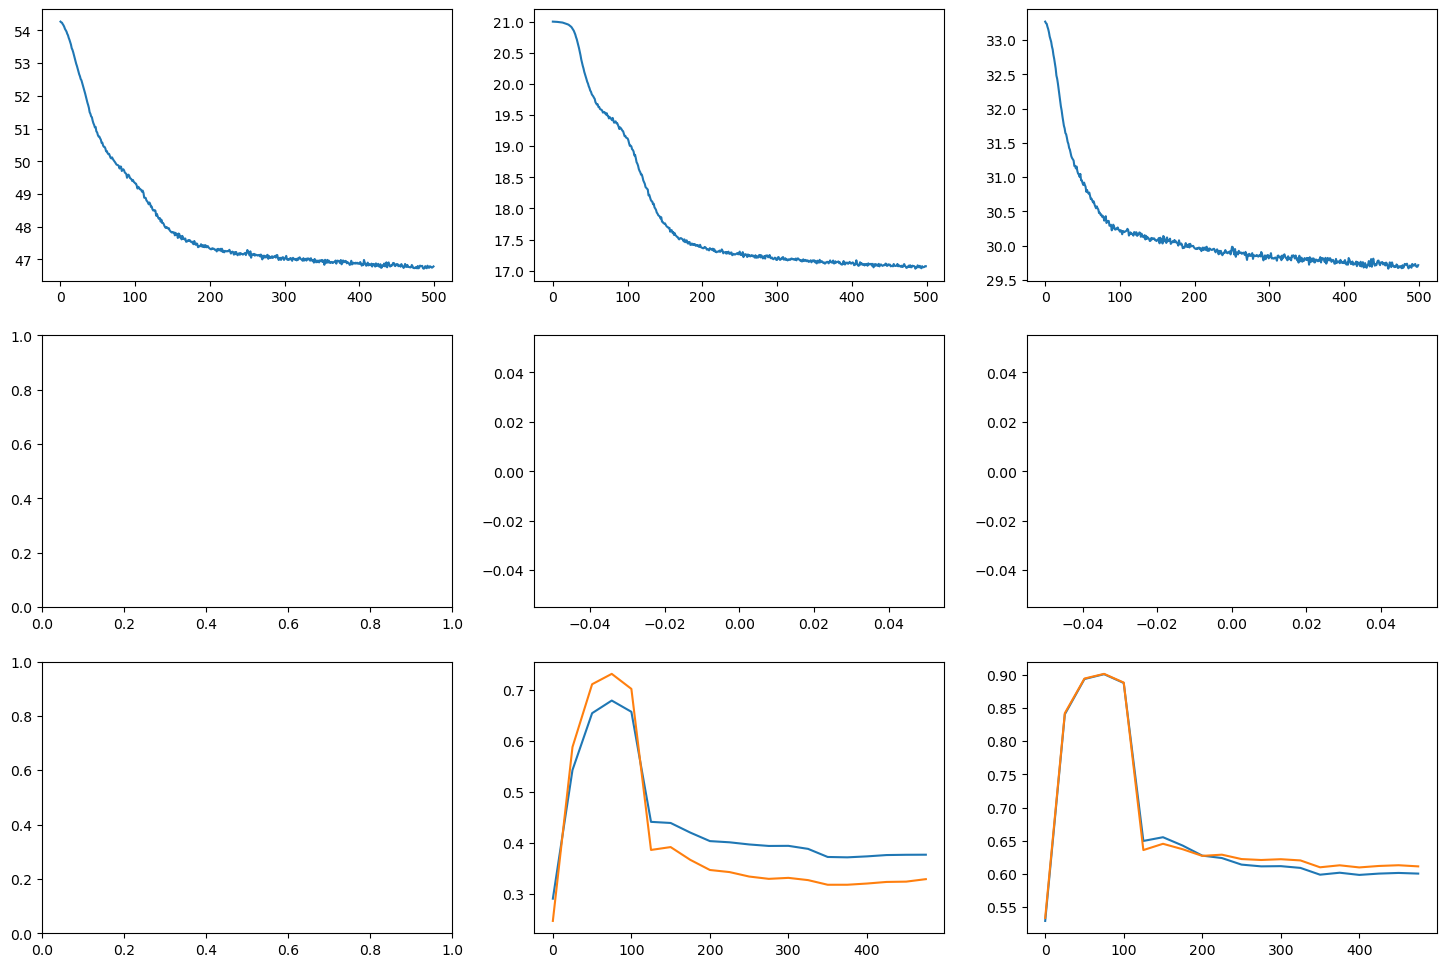

-------------------------------------
[MAX]NMI:  0.6791870561195924
[MAX]ARI:  0.7315621733755808
[MAX]ACC:  0.9011570247933884
[MAX]F1:  0.9016567458563106


In [227]:



def train1(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer, x, graph_dict):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1s, z2s, c1s, c2s = encoder_model(x, graph_dict)
    con_loss = 0
    for i in range(len(z1s)):
        con_loss += contrast_model(z1s[i], z2s[i])
    clu_loss = 0
    # for i in range(len(c1s)):
    #     clu_loss += cluster_model(c1s[i], c2s[i])

    for i in range(len(c1s)):
        clu_loss += cluster_model(c1s[i].t(), c2s[i].t())
    for i in range(len(c1s)):
        clu_loss += cluster_model(c1s[i], c2s[i])
    loss = con_loss + clu_loss

    # loss = con_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item()


def train2(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer, x, graph_dict):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1s, z2s, c1s, c2s = encoder_model(x, graph_dict)
    con_loss = 0
    for i in range(len(z1s)):
        con_loss += contrast_model(z1s[i], z2s[i])
    for i in range(len(z1s)):
        con_loss += contrast_model2(z1s[i], z2s[int((i + 1) % len(z1s))])
    # con_loss += contrast_model2(z1s[0], z2s[1])
    clu_loss = 0
    # for i in range(len(c1s)):
    #     clu_loss += cluster_model(c1s[i], c2s[i])

    for i in range(len(c1s)):
        clu_loss += cluster_model(c1s[i].t(), c2s[i].t())
    for i in range(len(c1s)):
        clu_loss += cluster_model(c1s[i], c2s[i])
    loss = con_loss + clu_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), clu_loss.item()


def train3(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer, x, graph_dict, c):
    encoder_model.train()
    optimizer.zero_grad()
    _, z1s, z2s, c1s, c2s = encoder_model(x, graph_dict)
    plabel = torch.argmax(c, dim=1)
    mask = torch.gt(torch.max(c, dim=1).values, 0.7)
    extra_pos_mask = torch.eq(plabel, plabel.unsqueeze(dim=1)).to('cuda')
    # construct extra supervision signals for only training samples
    extra_pos_mask[~mask][:, ~mask] = False
    extra_pos_mask.fill_diagonal_(False)
    # pos_mask: [N, 2N] for both inter-view and intra-view samples
    extra_pos_mask = torch.cat([extra_pos_mask, extra_pos_mask], dim=1).to('cuda')
    # fill interview positives only; pos_mask for intraview samples should have zeros in diagonal
    extra_pos_mask.fill_diagonal_(True)

    extra_neg_mask = torch.ne(plabel, plabel.unsqueeze(dim=1)).to('cuda')
    extra_neg_mask[~mask][:, ~mask] = True
    extra_neg_mask.fill_diagonal_(False)
    extra_neg_mask = torch.cat([extra_neg_mask, extra_neg_mask], dim=1).to('cuda')


    con_loss = 0
    # for i in range(len(z1s)):
    #     con_loss += contrast_model(h1=z1s[i], h2=z2s[i], extra_pos_mask=extra_pos_mask, extra_neg_mask=extra_neg_mask)
    con_loss += contrast_model(h1=z1s[0], h2=z2s[0])
    con_loss += contrast_model(h1=z1s[1], h2=z2s[1], extra_pos_mask=extra_pos_mask, extra_neg_mask=extra_neg_mask)
    for i in range(len(z1s)):
        con_loss += contrast_model2(z1s[i], z2s[int((i + 1) % len(z1s))])
    # con_loss += contrast_model2(z1s[0], z2s[1])
    clu_loss = 0
    # for i in range(len(c1s)):
    #     clu_loss += cluster_model(c1s[i], c2s[i])

    for i in range(len(c1s)):
        clu_loss += cluster_model(c1s[i].t(), c2s[i].t())
    for i in range(len(c1s)):
        clu_loss += cluster_model(c1s[i], c2s[i])
    # clu_loss += cluster_model(c1s[0], c2s[0]) + cluster_model(c1s[0].t(), c2s[0].t())
    loss = con_loss + clu_loss

    loss.backward()
    optimizer.step()
    return loss.item(), con_loss.item(), clu_loss.item()


encoder_model = Encoder(graph_dict=graph_dict, augmentor=augmentor_dict, hidden_dim=256, num_heads=1, n_clusters=3,
                        num_layers=2).to(device)
print("model have {} paramerters in total".format(sum(x.numel() for x in encoder_model.parameters())))

contrast_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)
contrast_model2 = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=False).to(device)
cluster_model = DualBranchContrast(loss=L.InfoNCE(tau=0.2), mode='L2L', intraview_negs=True).to(device)
optimizer1 = Adam(encoder_model.parameters(), lr=0.0003, weight_decay=1e-5)
optimizer = Adam(encoder_model.parameters(), lr=0.0001, weight_decay=1e-5)
losss = []
clu_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
epochs1 = 0
epochs2 = 0
epochs3 = 500

kmeans = KMeans(n_clusters=3, n_init=20)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))

with tqdm(total=epochs1, desc='(T)') as pbar:
    for epoch in range(epochs1):
        encoder_model.train()

        loss, con_loss = train1(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer1, x,
                                graph_dict)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss})
        pbar.update()

with tqdm(total=epochs2, desc='(T)') as pbar:
    for epoch in range(epochs2):
        encoder_model.train()

        loss, con_loss, clu_loss = train2(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer, x,
                                          graph_dict)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'clu_loss': clu_loss})
        pbar.update()

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                zs, _, _, _, _ = encoder_model(x, graph_dict)
            # z = torch.cat((zs[0], zs[1]), dim=1)
            z = zs[0]
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))

            acc, f1 = cluster_acc(y.cpu().numpy(), pred)

            accs.append((epoch, acc))
            f1s.append((epoch, f1))
if len(nmis) != 0:
    print('[MAX]NMI: ', max([i[1] for i in nmis]))
    print('[MAX]ARI: ', max([i[1] for i in aris]))
    print('[MAX]ACC: ', max([i[1] for i in accs]))
    print('[MAX]F1: ', max([i[1] for i in f1s]))
axes[1][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[1][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[1][2].plot([i[0] for i in aris], [i[1] for i in f1s])
losss = []
clu_losss = []
con_losss = []
nmis = []
aris = []
ratios = []
accs = []
f1s = []
# contrast_model = Self_SupConLoss(temperature=0.5)
optimizer = Adam(encoder_model.parameters(), lr=0.0001, weight_decay=1e-5)
with torch.no_grad():
    encoder_model.eval()
    zs, cs = encoder_model.cluster(x, graph_dict)
    c = cs[0]
with tqdm(total=epochs3, desc='(T)') as pbar:
    for epoch in range(epochs3):
        encoder_model.train()

        loss, con_loss, clu_loss = train3(encoder_model, contrast_model, contrast_model2, cluster_model, optimizer, x,
                                          graph_dict, c)
        pbar.set_postfix({'loss': loss, 'con_loss': con_loss, 'clu_loss': clu_loss})
        pbar.update()
        losss.append(loss)
        clu_losss.append(clu_loss)
        con_losss.append(con_loss)
        # if epoch % 1 == 0:
        with torch.no_grad():
                encoder_model.eval()
                zs, cs = encoder_model.cluster(x, graph_dict)
                # plabel = torch.argmax(cs[0], -1)
                c = cs[0]

        if epoch % 25 == 0:
            with torch.no_grad():
                encoder_model.eval()
                zs, _, _, _, _ = encoder_model(x, graph_dict)
            # z = torch.cat((zs[0], zs[1]), dim=1)
            z = zs[0]
            pred = kmeans.fit_predict(z.cpu())
            nmi = normalized_mutual_info_score(pred, y.cpu())
            ari = adjusted_rand_score(pred, y.cpu())
            nmis.append((epoch, nmi))
            aris.append((epoch, ari))

            acc, f1 = cluster_acc(y.cpu().numpy(), pred)

            accs.append((epoch, acc))
            f1s.append((epoch, f1))

axes[0][0].plot(range(epochs3), losss)
axes[0][1].plot(range(epochs3), clu_losss)
axes[0][2].plot(range(epochs3), con_losss)
axes[2][1].plot([i[0] for i in nmis], [i[1] for i in nmis])
axes[2][1].plot([i[0] for i in aris], [i[1] for i in aris])
axes[2][2].plot([i[0] for i in aris], [i[1] for i in accs])
axes[2][2].plot([i[0] for i in aris], [i[1] for i in f1s])
plt.show()
if len(nmis) != 0:
    print('-------------------------------------')
    print('[MAX]NMI: ', max([i[1] for i in nmis]))
    print('[MAX]ARI: ', max([i[1] for i in aris]))
    print('[MAX]ACC: ', max([i[1] for i in accs]))
    print('[MAX]F1: ', max([i[1] for i in f1s]))
# test_result = test(encoder_model, data)
# print(f'(E): Best test F1Mi={test_result["micro_f1"]:.4f}, F1Ma={test_result["macro_f1"]:.4f}')


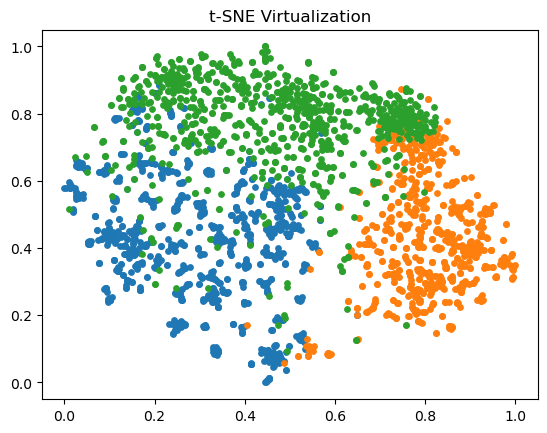

In [228]:

from sklearn import manifold, datasets

tsne = manifold.TSNE(n_components=2, init='pca')

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _ = encoder_model(x, graph_dict, edge_index)
    # z = torch.cat((zs[0], zs[1]), dim=1)
    z = zs[0]
    pred = kmeans.fit_predict(z.cpu())
X_tsne = tsne.fit_transform(z.cpu().numpy())
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_norm = (X_tsne - x_min) / (x_max - x_min)

d = np.where(pred == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(pred == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()



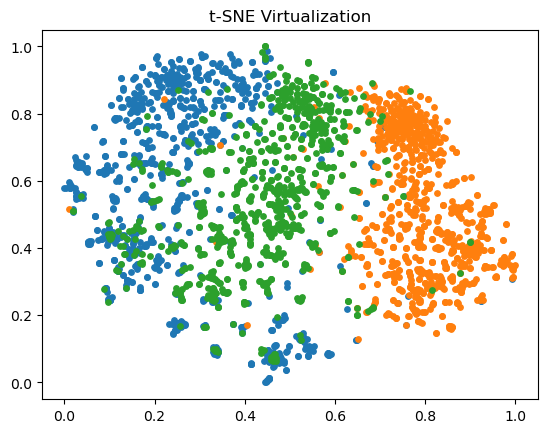

In [229]:
d = np.where(y.cpu() == 0)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 1)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 2)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)
d = np.where(y.cpu() == 3)
plt.scatter(X_norm[d, 0], X_norm[d, 1], s=15)

plt.title('t-SNE Virtualization')
plt.show()

In [230]:
with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _ = encoder_model(x, graph_dict)
    z = torch.cat((zs[0], zs[1]), dim=1)
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print(ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _ = encoder_model(x, graph_dict)
    z = zs[0]
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print('z0', ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _ = encoder_model(x, graph_dict)
    z = zs[1]
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print('z1', ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, _, _, _, _ = encoder_model(x, graph_dict)
    z = zs[0] + zs[1]
    pred = kmeans.fit_predict(z.cpu())
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print(ari, nmi, acc, f1)

with torch.no_grad():
    encoder_model.eval()
    zs, cs = encoder_model.cluster(x, graph_dict)
    pred = torch.argmax(cs[0], -1).cpu().numpy()
    nmi = normalized_mutual_info_score(pred, y.cpu())
    ari = adjusted_rand_score(pred, y.cpu())

    acc, f1 = cluster_acc(y.cpu().numpy(), pred)
    print(ari, nmi, acc, f1)

0.45964670233677735 0.5007849847644171 0.7084297520661157 0.7010692104863225
z0 0.32431518325166403 0.37247074100187844 0.5950413223140496 0.6054881002461058
z1 0.43880193132336803 0.4677914310268165 0.6968595041322314 0.6890005414901778
0.4608580704919787 0.5032527974175958 0.7087603305785124 0.7014712656632719
0.2528029348733834 0.3194918381405965 0.543801652892562 0.5590881158639194


In [231]:

z = torch.cat((zs[0], zs[1]), dim=1)
print(z.size())

torch.Size([3025, 512])
